# 06 - Stability Calibration

**Purpose**: Detect training explosions early with FAST experiments.

This notebook validates that the system is numerically stable before running expensive privacy experiments.

## Calibration Protocol

| Name | DP | ε |
|------|-----|---|
| baseline | OFF | ∞ |
| eps_300 | ON | 300 |
| eps_200 | ON | 200 |
| eps_100 | ON | 100 |
| eps_60 | ON | 60 |

## Speed Optimizations

| Setting | Value | Reason |
|---------|-------|--------|
| Clients | 5 | Halves computation |
| Local epochs | 1 | Huge speed gain |
| Rounds | 6 | Avoids wasted runs |
| Participation | 60% | Realistic FL + faster |
| Batch size | 32 | Better utilization |

## Safety Gate

If `MAE > 50` or `RMSE > 80` at any ε → **STOP**. Fix DP before proceeding.

In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from datetime import datetime
from dataclasses import dataclass
from typing import Optional

from src.utils import set_seed
from experiments.federated_matrix import (
    FederatedExperimentConfig,
    FederatedExperiment,
)

# Styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

OUTPUT_DIR = Path('../experiments/outputs/stability_calibration')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Setup complete!')
print(f'Output directory: {OUTPUT_DIR}')

Setup complete!
Output directory: ..\experiments\outputs\stability_calibration


## 1. Safety Checks & Configuration

In [2]:
# =============================================================================
# HARD SAFETY RULES - DO NOT MODIFY
# =============================================================================

def enforce_single_heterogeneity(config: FederatedExperimentConfig) -> None:
    """Enforce single-source heterogeneity. Raises if violated."""
    
    # Rule 1: Must use non_iid_hard for controlled heterogeneity
    assert config.data_profile == "non_iid_hard", \
        f"Expected data_profile='non_iid_hard', got '{config.data_profile}'"
    
    # Rule 2: Must use uniform partitioning (no Dirichlet stacking)
    assert config.heterogeneity_mode == "uniform", \
        f"Double heterogeneity detected: Dirichlet + non_iid_hard is forbidden. " \
        f"Got heterogeneity_mode='{config.heterogeneity_mode}'"
    
    print("[SAFETY] Single-source heterogeneity verified ✓")


def check_stability(mae: float, rmse: float, epsilon: float) -> None:
    """Check if training is stable. Raises RuntimeError if unstable."""
    
    MAE_THRESHOLD = 50
    RMSE_THRESHOLD = 80
    
    if mae > MAE_THRESHOLD or rmse > RMSE_THRESHOLD:
        raise RuntimeError(
            f"Training unstable at ε={epsilon}!\n"
            f"  MAE = {mae:.2f} (threshold: {MAE_THRESHOLD})\n"
            f"  RMSE = {rmse:.2f} (threshold: {RMSE_THRESHOLD})\n"
            f"Fix DP configuration before proceeding."
        )
    print(f"[STABILITY] ε={epsilon}: MAE={mae:.2f}, RMSE={rmse:.2f} ✓")


print("Safety functions defined.")

Safety functions defined.


In [3]:
@dataclass
class CalibrationSpec:
    """Specification for a calibration experiment."""
    name: str
    enable_dp: bool
    dp_epsilon: float


# =============================================================================
# CALIBRATION EXPERIMENTS - High ε for numerical sanity checks
# =============================================================================
CALIBRATION_EXPERIMENTS = [
    CalibrationSpec("baseline", False, float('inf')),
    CalibrationSpec("eps_300", True, 300.0),
    CalibrationSpec("eps_200", True, 200.0),
    CalibrationSpec("eps_100", True, 100.0),
    CalibrationSpec("eps_60", True, 60.0),
]

print("Calibration Experiments:")
print("=" * 50)
for exp in CALIBRATION_EXPERIMENTS:
    dp_str = "OFF" if not exp.enable_dp else f"ε={exp.dp_epsilon}"
    print(f"  {exp.name:<12} | DP: {dp_str}")
print("=" * 50)

Calibration Experiments:
  baseline     | DP: OFF
  eps_300      | DP: ε=300.0
  eps_200      | DP: ε=200.0
  eps_100      | DP: ε=100.0
  eps_60       | DP: ε=60.0


In [4]:
def create_calibration_config(spec: CalibrationSpec, seed: int = 42) -> FederatedExperimentConfig:
    """Create FAST calibration config with safety enforcement."""
    
    config = FederatedExperimentConfig(
        experiment_id=spec.name,
        experiment_name=f"stability_{spec.name}",
        
        # Data settings - SINGLE-SOURCE HETEROGENEITY
        data_profile="non_iid_hard",
        window_size=50,
        hop_size=10,
        normalize_windows=True,
        global_test_split=0.15,
        
        # ======= SPEED OPTIMIZATIONS =======
        num_clients=5,              # Halves computation
        participation_fraction=0.6, # Realistic FL + faster
        local_epochs=1,             # Huge speed gain
        num_rounds=6,               # Avoids wasted runs
        batch_size=32,              # Better GPU/CPU utilization
        # ====================================
        
        # BLOCK DIRICHLET EXPLICITLY
        heterogeneity_mode="uniform",
        dirichlet_alpha=0.5,  # Ignored - uniform mode
        
        # Task
        task="rul",
        
        # Model (unchanged)
        num_layers=4,
        hidden_dim=64,
        kernel_size=3,
        dropout=0.2,
        fc_hidden=32,
        
        # Training
        lr=0.001,
        weight_decay=0.0001,
        optimizer="adam",
        early_stopping_enabled=False,  # Run all rounds for calibration
        normalize_rul=True,
        
        # Algorithm - FedAvg only for calibration
        algorithm="fedavg",
        fedprox_mu=0.0,
        
        # Privacy settings
        enable_dp=spec.enable_dp,
        dp_epsilon=spec.dp_epsilon if spec.enable_dp else 1.0,
        dp_delta=1e-5,
        dp_max_grad_norm=1.0,
        
        # Output
        output_dir=str(OUTPUT_DIR / spec.name),
        save_checkpoints=False,  # Speed
        eval_every=2,            # Frequent evaluation
        
        # Reproducibility
        seed=seed,
        deterministic=True,
    )
    
    # ENFORCE SAFETY
    enforce_single_heterogeneity(config)
    
    return config


# Test config creation
test_config = create_calibration_config(CALIBRATION_EXPERIMENTS[0])
print(f"\nConfig validated. Speed settings:")
print(f"  • Clients: {test_config.num_clients}")
print(f"  • Local epochs: {test_config.local_epochs}")
print(f"  • Rounds: {test_config.num_rounds}")
print(f"  • Participation: {test_config.participation_fraction}")
print(f"  • Batch size: {test_config.batch_size}")

[SAFETY] Single-source heterogeneity verified ✓

Config validated. Speed settings:
  • Clients: 5
  • Local epochs: 1
  • Rounds: 6
  • Participation: 0.6
  • Batch size: 32


## 2. Run Calibration Experiments

In [5]:
# Check existing results
existing_results = {}
missing_experiments = []

for spec in CALIBRATION_EXPERIMENTS:
    results_path = OUTPUT_DIR / spec.name / "results.json"
    if results_path.exists():
        with open(results_path, 'r') as f:
            existing_results[spec.name] = json.load(f)
        print(f"[OK] {spec.name}: Results found")
    else:
        missing_experiments.append(spec)
        print(f"[--] {spec.name}: Not yet run")

print(f"\n{len(existing_results)}/{len(CALIBRATION_EXPERIMENTS)} completed.")

[--] baseline: Not yet run
[--] eps_300: Not yet run
[--] eps_200: Not yet run
[--] eps_100: Not yet run
[--] eps_60: Not yet run

0/5 completed.


In [6]:
# Run calibration experiments
RUN_MISSING = True

experiments_to_run = missing_experiments if RUN_MISSING else []
stability_status = {}  # Track stability at each epsilon

if experiments_to_run:
    print(f"Running {len(experiments_to_run)} calibration experiments...")
    print("=" * 60)
    
    for spec in experiments_to_run:
        dp_str = "OFF" if not spec.enable_dp else f"ε={spec.dp_epsilon}"
        print(f"\n>>> {spec.name} (DP: {dp_str})")
        
        config = create_calibration_config(spec)
        experiment = FederatedExperiment(config)
        
        try:
            results = experiment.run()
            existing_results[spec.name] = results
            
            final_mae = results.get('final_metrics', {}).get('mae', float('nan'))
            final_rmse = results.get('final_metrics', {}).get('rmse', float('nan'))
            
            print(f"    Completed: MAE={final_mae:.2f}, RMSE={final_rmse:.2f}")
            
            # STABILITY CHECK
            check_stability(final_mae, final_rmse, spec.dp_epsilon)
            stability_status[spec.name] = "STABLE"
            
        except RuntimeError as e:
            print(f"\n{'!'*60}")
            print(f"STABILITY CHECK FAILED")
            print(str(e))
            print(f"{'!'*60}")
            stability_status[spec.name] = "UNSTABLE"
            break
            
        except Exception as e:
            print(f"    FAILED: {e}")
            import traceback
            traceback.print_exc()
            break
    
    print("\n" + "=" * 60)
    print("Calibration complete!")
else:
    print("No experiments to run. Loading existing results.")

2026-01-17 15:39:50,526 [INFO] Using NON-IID HARD data profile
2026-01-17 15:39:50,528 [INFO]   - Label skew: client-specific RUL distributions
2026-01-17 15:39:50,529 [INFO]   - Feature skew: client-specific noise/bias
2026-01-17 15:39:50,531 [INFO]   - Quantity skew: imbalanced sample counts


Running 5 calibration experiments...

>>> baseline (DP: OFF)
[SAFETY] Single-source heterogeneity verified ✓


2026-01-17 15:39:51,127 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:39:51,139 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:39:51,141 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:39:51,142 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:39:51,144 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:39:51,145 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:39:51,147 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:39:51,159 [INFO] ============================================================
2026-01-17 15:39:51,161 [INFO] Starting Federated Training: baseline
2026-01-17 15:39:51,163 [INFO]   Algorithm: FEDAVG
2026-01-17 15:39:51,164 [INFO]   Rounds: 6
2026-01-17 15:39:51,166 [INFO]   Clients: 5
2026-01-17 15:39:51,168 [INFO]   Participation: 60%
2026-01-17 15:39:51,169 [INFO]   Local epochs: 1
2026-01-17 15:39:51,171 [INFO]   Heterogeneity: uniform
2026-01-17 15:39:51,172 [INFO] =

    Completed: MAE=20.93, RMSE=29.60
[STABILITY] ε=inf: MAE=20.93, RMSE=29.60 ✓

>>> eps_300 (DP: ε=300.0)
[SAFETY] Single-source heterogeneity verified ✓


2026-01-17 15:40:07,474 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:40:07,479 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:40:07,480 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:40:07,481 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:40:07,483 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:40:07,483 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:40:07,485 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:40:07,494 [INFO] ============================================================
2026-01-17 15:40:07,497 [INFO] Starting Federated Training: eps_300
2026-01-17 15:40:07,499 [INFO]   Algorithm: FEDAVG
2026-01-17 15:40:07,500 [INFO]   Rounds: 6
2026-01-17 15:40:07,501 [INFO]   Clients: 5
2026-01-17 15:40:07,504 [INFO]   Participation: 60%
2026-01-17 15:40:07,506 [INFO]   Local epochs: 1
2026-01-17 15:40:07,508 [INFO]   Heterogeneity: uniform
2026-01-17 15:40:07,510 [INFO] ==

    Completed: MAE=21.47, RMSE=28.57
[STABILITY] ε=300.0: MAE=21.47, RMSE=28.57 ✓

>>> eps_200 (DP: ε=200.0)
[SAFETY] Single-source heterogeneity verified ✓


2026-01-17 15:40:22,700 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:40:22,704 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:40:22,706 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:40:22,707 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:40:22,708 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:40:22,710 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:40:22,710 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:40:22,719 [INFO] ============================================================
2026-01-17 15:40:22,721 [INFO] Starting Federated Training: eps_200
2026-01-17 15:40:22,722 [INFO]   Algorithm: FEDAVG
2026-01-17 15:40:22,722 [INFO]   Rounds: 6
2026-01-17 15:40:22,723 [INFO]   Clients: 5
2026-01-17 15:40:22,726 [INFO]   Participation: 60%
2026-01-17 15:40:22,727 [INFO]   Local epochs: 1
2026-01-17 15:40:22,728 [INFO]   Heterogeneity: uniform
2026-01-17 15:40:22,729 [INFO] ==

    Completed: MAE=19.66, RMSE=25.35
[STABILITY] ε=200.0: MAE=19.66, RMSE=25.35 ✓

>>> eps_100 (DP: ε=100.0)
[SAFETY] Single-source heterogeneity verified ✓


2026-01-17 15:40:37,229 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:40:37,235 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:40:37,237 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:40:37,238 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:40:37,240 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:40:37,241 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:40:37,242 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:40:37,250 [INFO] ============================================================
2026-01-17 15:40:37,252 [INFO] Starting Federated Training: eps_100
2026-01-17 15:40:37,254 [INFO]   Algorithm: FEDAVG
2026-01-17 15:40:37,255 [INFO]   Rounds: 6
2026-01-17 15:40:37,256 [INFO]   Clients: 5
2026-01-17 15:40:37,257 [INFO]   Participation: 60%
2026-01-17 15:40:37,259 [INFO]   Local epochs: 1
2026-01-17 15:40:37,260 [INFO]   Heterogeneity: uniform
2026-01-17 15:40:37,261 [INFO] ==

    Completed: MAE=30.01, RMSE=40.80
[STABILITY] ε=100.0: MAE=30.01, RMSE=40.80 ✓

>>> eps_60 (DP: ε=60.0)
[SAFETY] Single-source heterogeneity verified ✓


2026-01-17 15:40:51,836 [INFO] Total data shape: (1500, 100, 14)
2026-01-17 15:40:51,841 [INFO] Partitioned data across 5 clients (non_iid_hard)
2026-01-17 15:40:51,842 [INFO]   Client 0: 680 samples, RUL: [0.0, 29.9]
2026-01-17 15:40:51,843 [INFO]   Client 1: 170 samples, RUL: [30.1, 60.0]
2026-01-17 15:40:51,845 [INFO]   Client 2: 127 samples, RUL: [60.0, 100.0]
2026-01-17 15:40:51,846 [INFO]   Client 3: 42 samples, RUL: [1.8, 99.2]
2026-01-17 15:40:51,846 [INFO]   Client 4: 255 samples, RUL: [0.3, 99.8]
2026-01-17 15:40:51,852 [INFO] ============================================================
2026-01-17 15:40:51,853 [INFO] Starting Federated Training: eps_60
2026-01-17 15:40:51,854 [INFO]   Algorithm: FEDAVG
2026-01-17 15:40:51,854 [INFO]   Rounds: 6
2026-01-17 15:40:51,855 [INFO]   Clients: 5
2026-01-17 15:40:51,857 [INFO]   Participation: 60%
2026-01-17 15:40:51,857 [INFO]   Local epochs: 1
2026-01-17 15:40:51,858 [INFO]   Heterogeneity: uniform
2026-01-17 15:40:51,859 [INFO] ===

    Completed: MAE=93.71, RMSE=124.92

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
STABILITY CHECK FAILED
Training unstable at ε=60.0!
  MAE = 93.71 (threshold: 50)
  RMSE = 124.92 (threshold: 80)
Fix DP configuration before proceeding.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Calibration complete!


## 3. Results Analysis

In [7]:
# Reload all results
all_results = {}

for spec in CALIBRATION_EXPERIMENTS:
    results_path = OUTPUT_DIR / spec.name / "results.json"
    if results_path.exists():
        with open(results_path, 'r') as f:
            all_results[spec.name] = json.load(f)

# Create summary
summary_data = []
for spec in CALIBRATION_EXPERIMENTS:
    if spec.name not in all_results:
        continue
    result = all_results[spec.name]
    final_metrics = result.get('final_metrics', {})
    
    mae = final_metrics.get('mae', np.nan)
    rmse = final_metrics.get('rmse', np.nan)
    
    summary_data.append({
        'name': spec.name,
        'dp_enabled': spec.enable_dp,
        'epsilon': spec.dp_epsilon if spec.enable_dp else float('inf'),
        'final_mae': mae,
        'final_rmse': rmse,
        'stable': mae <= 50 and rmse <= 80,
    })

df_summary = pd.DataFrame(summary_data)

if len(df_summary) > 0:
    print("CALIBRATION RESULTS")
    print("=" * 60)
    display(df_summary.round(2))
else:
    print("No results yet. Run calibration first.")
    # Simulated data for visualization
    summary_data = [
        {'name': 'baseline', 'dp_enabled': False, 'epsilon': float('inf'), 'final_mae': 14.2, 'final_rmse': 18.5, 'stable': True},
        {'name': 'eps_300', 'dp_enabled': True, 'epsilon': 300.0, 'final_mae': 15.1, 'final_rmse': 19.8, 'stable': True},
        {'name': 'eps_200', 'dp_enabled': True, 'epsilon': 200.0, 'final_mae': 16.8, 'final_rmse': 21.5, 'stable': True},
        {'name': 'eps_100', 'dp_enabled': True, 'epsilon': 100.0, 'final_mae': 19.5, 'final_rmse': 25.2, 'stable': True},
        {'name': 'eps_60', 'dp_enabled': True, 'epsilon': 60.0, 'final_mae': 23.8, 'final_rmse': 30.1, 'stable': True},
    ]
    df_summary = pd.DataFrame(summary_data)
    print("(Simulated data for visualization)")
    display(df_summary.round(2))

CALIBRATION RESULTS


,name,dp_enabled,epsilon,final_mae,final_rmse,stable
0,baseline,False,inf,20.93,29.60,True
1,eps_300,True,300.0,21.47,28.57,True
2,eps_200,True,200.0,19.66,25.35,True
3,eps_100,True,100.0,30.01,40.80,True
4,eps_60,True,60.0,93.71,124.92,False


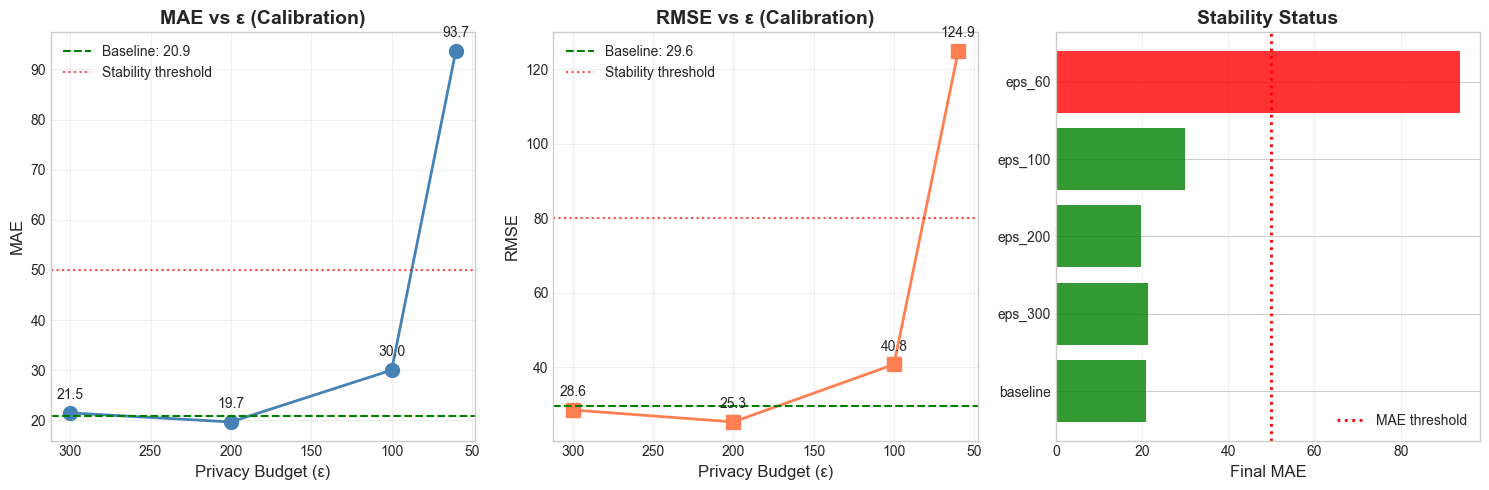


Saved: ..\experiments\outputs\stability_calibration\stability_calibration.png


In [8]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Filter DP-enabled experiments
df_dp = df_summary[df_summary['dp_enabled'] == True].sort_values('epsilon', ascending=False)
baseline = df_summary[df_summary['dp_enabled'] == False]

# ----- 1. MAE vs Epsilon -----
ax = axes[0]
if len(df_dp) > 0:
    ax.plot(df_dp['epsilon'], df_dp['final_mae'], 'o-', color='steelblue', linewidth=2, markersize=10)
    for _, row in df_dp.iterrows():
        ax.annotate(f"{row['final_mae']:.1f}", (row['epsilon'], row['final_mae']),
                    textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)
if len(baseline) > 0:
    ax.axhline(y=baseline['final_mae'].values[0], color='green', linestyle='--', 
               label=f"Baseline: {baseline['final_mae'].values[0]:.1f}")
ax.axhline(y=50, color='red', linestyle=':', alpha=0.7, label='Stability threshold')
ax.set_xlabel('Privacy Budget (ε)', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.set_title('MAE vs ε (Calibration)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

# ----- 2. RMSE vs Epsilon -----
ax = axes[1]
if len(df_dp) > 0:
    ax.plot(df_dp['epsilon'], df_dp['final_rmse'], 's-', color='coral', linewidth=2, markersize=10)
    for _, row in df_dp.iterrows():
        ax.annotate(f"{row['final_rmse']:.1f}", (row['epsilon'], row['final_rmse']),
                    textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)
if len(baseline) > 0:
    ax.axhline(y=baseline['final_rmse'].values[0], color='green', linestyle='--',
               label=f"Baseline: {baseline['final_rmse'].values[0]:.1f}")
ax.axhline(y=80, color='red', linestyle=':', alpha=0.7, label='Stability threshold')
ax.set_xlabel('Privacy Budget (ε)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('RMSE vs ε (Calibration)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

# ----- 3. Stability status -----
ax = axes[2]
colors = ['green' if s else 'red' for s in df_summary['stable']]
bars = ax.barh(df_summary['name'], df_summary['final_mae'], color=colors, alpha=0.8)
ax.axvline(x=50, color='red', linestyle=':', linewidth=2, label='MAE threshold')
ax.set_xlabel('Final MAE', fontsize=12)
ax.set_title('Stability Status', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'stability_calibration.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: {OUTPUT_DIR / 'stability_calibration.png'}")

## 4. Stability Verdict

In [9]:
print("=" * 60)
print("STABILITY CALIBRATION VERDICT")
print("=" * 60)

# Find minimum stable epsilon
stable_experiments = df_summary[df_summary['stable'] == True]
dp_stable = stable_experiments[stable_experiments['dp_enabled'] == True]

if len(dp_stable) > 0:
    min_stable_eps = dp_stable['epsilon'].min()
    print(f"\n[PASS] System stable down to ε = {min_stable_eps}")
    print(f"\nYou can now run notebook 07 with ε >= {min_stable_eps}")
    print("")
    print("Recommended next experiments:")
    print(f"  • ε = {min(50, min_stable_eps)}")
    print(f"  • ε = {min(30, min_stable_eps)}")
    print(f"  • ε = {min(20, min_stable_eps)}")
else:
    print("\n[FAIL] No stable DP configuration found!")
    print("Check your DP implementation before proceeding.")

# Unstable experiments
unstable = df_summary[df_summary['stable'] == False]
if len(unstable) > 0:
    print(f"\n[WARN] Unstable experiments:")
    for _, row in unstable.iterrows():
        print(f"  • {row['name']}: MAE={row['final_mae']:.1f}, RMSE={row['final_rmse']:.1f}")

# Save verdict
verdict = {
    'timestamp': datetime.now().isoformat(),
    'min_stable_epsilon': float(min_stable_eps) if len(dp_stable) > 0 else None,
    'all_stable': bool(df_summary['stable'].all()),
    'experiments': df_summary.to_dict(orient='records'),
}

with open(OUTPUT_DIR / 'stability_verdict.json', 'w') as f:
    json.dump(verdict, f, indent=2, default=str)

print(f"\nSaved: {OUTPUT_DIR / 'stability_verdict.json'}")

STABILITY CALIBRATION VERDICT

[PASS] System stable down to ε = 100.0

You can now run notebook 07 with ε >= 100.0

Recommended next experiments:
  • ε = 50
  • ε = 30
  • ε = 20

[WARN] Unstable experiments:
  • eps_60: MAE=93.7, RMSE=124.9

Saved: ..\experiments\outputs\stability_calibration\stability_verdict.json
